In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sentence_transformers import SentenceTransformer
import re
import json

In [2]:
with open('redditdata_combined.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Assuming the JSON has a structure like {'flair': {flair_name: {post_id: post_data}}}
# Flatten the nested structure
records = []
for flair, posts in data.get('flair', {}).items():
    for post_id, post_info in posts.items():
        record = {
            'post_id': post_id,
            'flair': flair,
            'title': post_info.get('title', ''),
            'text_body': post_info.get('text_body', ''),
            'author': post_info.get('author', ''),
            'score': post_info.get('score', 0),
            'num_comments': post_info.get('num_comments', 0)
        }
        records.append(record)

# Create a DataFrame
df = pd.DataFrame(records)
df

,post_id,flair,title,text_body,author,score,num_comments
0,1jwqkjk,Content Warning: Suicidal Thoughts / Self Harm,Struggling lately,I’m 16 and recently I’ve been feeling really d...,zkkkkkkkkk2008,1,1
1,1jwo3c6,Content Warning: Suicidal Thoughts / Self Harm,Went to hospital with suicidal thoughts,So I went to the hospital with an active plan ...,Frankenstien_Sloth,1,14
2,1jwnf53,Content Warning: Suicidal Thoughts / Self Harm,To the people I love,"**To the People I Love,**\n\nI’ve been thinkin...",Prestigious_Duck08,2,5
3,1jwnbsg,Content Warning: Suicidal Thoughts / Self Harm,Am i traumatized because I have no friends or ...,This is just a question I have been wondering ...,Routine-Pound-591,1,5
4,1jwmhvs,Content Warning: Suicidal Thoughts / Self Harm,I’m reaching breaking point,I am lost. I am broken. I am trapped \n\nFor t...,Difficult_Body_1707,1,2
...,...,...,...,...,...,...,...
1177,1jl64w7,Advice Wanted,Went from KV to just V last night and felt... ...,I was a little afraid this would be the case. ...,thesuspiciouszed,10,4
1178,1jl3tzz,Advice Wanted,I am depressed all the time and people start n...,I can't lie to myself that's I am ok . I tried...,Electronic-Ad3532,15,3
1179,1jixod4,Advice Wanted,Does it get better after high school or is it ...,I'm about to graduate from high school and all...,RickyDickyPubicBalls,14,23
1180,1jyv17t,TW: Abuse,I finally understood genuinely nobody cares ab...,I have been emotionally & physically abused si...,trynamakeitty,4,2


In [3]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^A-Za-z0-9\s]+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_title'] = df['title'].astype(str).apply(clean_text)
df['clean_text_body'] = df['text_body'].astype(str).apply(clean_text)

In [4]:

combined_texts = (df['clean_title'] + ' ' + df['clean_text_body']).tolist()


In [5]:
model = SentenceTransformer('all-MiniLM-L6-v2')
X_embed = model.encode(combined_texts, show_progress_bar=True)

Batches:   0%|          | 0/37 [00:00<?, ?it/s]

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=192)
X_pca = pca.fit_transform(X_embed)

In [7]:
X_norm = normalize(X_pca)

In [8]:
dbscan = DBSCAN(eps=0.3, min_samples=3,metric='cosine')
labels = dbscan.fit_predict(X_norm)


In [9]:
mask = labels != -1
if len(set(labels[mask])) > 1:
    score = silhouette_score(X_norm[mask], labels[mask], metric='cosine')
    print("Silhouette Score:", round(score, 4))
else:
    print("Not enough distinct clusters found for silhouette score.")


Silhouette Score: 0.702


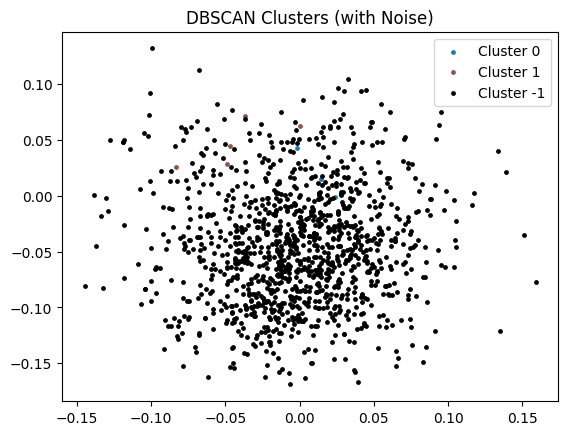

In [10]:
import numpy as np
import matplotlib.pyplot as plt
unique_labels = set(labels)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    class_mask = labels == k
    if k == -1:
        # Noise
        col = [0, 0, 0, 1]  # black
    plt.scatter(X_embed[class_mask, 0], X_embed[class_mask, 1],
                c=[col], s=6, label=f'Cluster {k}')
    
plt.legend()
plt.title("DBSCAN Clusters (with Noise)")
plt.show()
